# Lexicon-Based vs Embedding-Based Moral Scoring - All English Texts

This notebook compares two approaches for moral foundation scoring across **all English texts**:
1. **Lexicon-Based**: Simple word-counting from English MFD (mfd2.0.dic)
2. **Embedding-Based**: Semantic similarity using IndicSBERT (from English_Moral_Scoring.ipynb)

## Texts Analyzed:
- Aesop's Fables
- Grimm's Household Tales
- Hans Christian Andersen Fairy Tales
- Just So Stories
- Morals and Manners
- Peter Rabbit

## Goal:
Evaluate which method better captures moral content in English children's literature and moral texts.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import cohen_kappa_score
import os
import glob

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load English MFD Dictionary

In [2]:
# Parse English MFD from mfd2.0.dic file
english_mfd = {}

with open('../mfd2.0.dic', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line and not line.startswith('%') and not (line and line[0].isdigit()):
            parts = line.split()
            if len(parts) >= 2:
                try:
                    category_num = int(parts[-1])
                    word = ' '.join(parts[:-1]).lower()  # Convert to lowercase for matching
                    
                    # Map category numbers to foundation names
                    category_map = {
                        1: 'care.virtue',
                        2: 'care.vice',
                        3: 'fairness.virtue',
                        4: 'fairness.vice',
                        5: 'loyalty.virtue',
                        6: 'loyalty.vice',
                        7: 'authority.virtue',
                        8: 'authority.vice',
                        9: 'sanctity.virtue',
                        10: 'sanctity.vice'
                    }
                    
                    foundation = category_map.get(category_num)
                    if foundation:
                        if foundation not in english_mfd:
                            english_mfd[foundation] = []
                        english_mfd[foundation].append(word)
                except ValueError:
                    continue

print("English MFD Loaded:")
for foundation, words in sorted(english_mfd.items()):
    print(f"  {foundation}: {len(words)} words")

# Show sample words
print("\nSample words from care.virtue:")
print(english_mfd['care.virtue'][:5])

moral_foundations = list(english_mfd.keys())
print(f"\nTotal foundations: {len(moral_foundations)}")

English MFD Loaded:
  authority.vice: 130 words
  authority.virtue: 301 words
  care.vice: 288 words
  care.virtue: 182 words
  fairness.vice: 236 words
  fairness.virtue: 115 words
  loyalty.vice: 49 words
  loyalty.virtue: 143 words
  sanctity.vice: 388 words
  sanctity.virtue: 272 words

Sample words from care.virtue:
['compassion', 'empathy', 'kindness', 'caring', 'generosity']

Total foundations: 10


## 2. Load All English Texts and Embedding Results

In [3]:
# Get all CSV files from processedDataEnglish folder
csv_files = glob.glob('processedDataEnglish/*.csv')
csv_files.sort()

print("Found CSV files:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Dictionary to store all data
texts_data = {}
embedding_data = {}

# Load each text
for csv_file in csv_files:
    basename = os.path.basename(csv_file).replace('_cleaned.csv', '')
    
    # Load original text
    df = pd.read_csv(csv_file)
    texts_data[basename] = df
    
    # Load corresponding embedding results
    embedding_file = f'english-step3-results/{basename}_cleaned_moral_scores.csv'
    if os.path.exists(embedding_file):
        embedding_df = pd.read_csv(embedding_file)
        embedding_data[basename] = embedding_df
        print(f"\n✓ {basename}: {len(df)} texts loaded with embedding results")
    else:
        print(f"\n⚠ {basename}: {len(df)} texts loaded (NO embedding results found)")

print(f"\nTotal texts loaded: {len(texts_data)}")
print(f"Total with embedding results: {len(embedding_data)}")

Found CSV files:
  - aesops_fables_cleaned.csv
  - grimm_tales_cleaned.csv
  - hans_christian_andersen_cleaned.csv
  - just_so_stories_cleaned.csv
  - morals_manners_cleaned.csv
  - peter_rabbit_cleaned.csv

✓ aesops_fables: 284 texts loaded with embedding results

✓ grimm_tales: 210 texts loaded with embedding results

✓ hans_christian_andersen: 202 texts loaded with embedding results

✓ just_so_stories: 12 texts loaded with embedding results

✓ morals_manners: 131 texts loaded with embedding results

✓ peter_rabbit: 1 texts loaded with embedding results

Total texts loaded: 6
Total with embedding results: 6


## 3. Implement Lexicon-Based Scoring

### Method:
For each text:
1. Tokenize (split into words)
2. Count matches with each moral foundation in English MFD
3. Calculate normalized scores (matches / total words)
4. Identify dominant moral (highest score)

In [4]:
def tokenize_english(text):
    """
    Simple English tokenization - split by whitespace and remove punctuation.
    """
    import re
    # Convert to string and lowercase
    text = str(text).lower()
    # Keep only alphanumeric and spaces
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    tokens = text.split()
    return tokens

def lexicon_score_text(text, mfd_dict):
    """
    Score a text using lexicon-based approach.
    
    Returns:
    - raw_counts: dict of {foundation: count}
    - normalized_scores: dict of {foundation: count/total_words}
    - dominant_moral: foundation with highest count
    - dominant_score: count of dominant moral
    """
    tokens = tokenize_english(text)
    total_words = len(tokens)
    
    # Count matches for each foundation
    raw_counts = {foundation: 0 for foundation in mfd_dict.keys()}
    
    for token in tokens:
        for foundation, word_list in mfd_dict.items():
            if token in word_list:
                raw_counts[foundation] += 1
    
    # Normalize by total words (TF normalization)
    normalized_scores = {
        foundation: count / total_words if total_words > 0 else 0
        for foundation, count in raw_counts.items()
    }
    
    # Dominant moral
    if sum(raw_counts.values()) > 0:
        dominant_moral = max(raw_counts, key=raw_counts.get)
        dominant_score = raw_counts[dominant_moral]
    else:
        dominant_moral = None
        dominant_score = 0
    
    return raw_counts, normalized_scores, dominant_moral, dominant_score

# Test on sample - find the text column properly
sample_df = list(texts_data.values())[0]
# Find text column
text_col = None
for col in ['text', 'story', 'fable', 'tale', 'content']:
    if col in sample_df.columns:
        text_col = col
        break
if text_col is None:
    for col in sample_df.columns:
        if sample_df[col].dtype == 'object':
            avg_len = sample_df[col].astype(str).str.len().mean()
            if avg_len > 50:
                text_col = col
                break

sample_text = sample_df.iloc[0][text_col] if text_col else str(sample_df.iloc[0].values[-1])
raw, norm, dom, score = lexicon_score_text(sample_text, english_mfd)
print(f"Sample text: {str(sample_text)[:100]}...")
print(f"\nDominant moral: {dom} (score: {score})")
print(f"Non-zero foundations: {[k for k, v in raw.items() if v > 0]}")

Sample text: A hungry Fox saw some fine bunches of Grapes hanging from a vine that was trained along a high trell...

Dominant moral: sanctity.virtue (score: 1)
Non-zero foundations: ['sanctity.virtue']


## 4. Apply Lexicon-Based Scoring to All Texts

In [5]:
# Dictionary to store lexicon results
lexicon_results = {}

print("="*70)
print("PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH")
print("="*70)

for text_name, df in texts_data.items():
    print(f"\nProcessing {text_name}...")
    
    # Determine which column contains the text
    text_column = None
    for col in ['text', 'story', 'fable', 'tale', 'content']:
        if col in df.columns:
            text_column = col
            break
    
    if text_column is None:
        # Use the last column that has substantial text
        for col in df.columns:
            if df[col].dtype == 'object' and col.lower() not in ['title', 'number', 'id']:
                avg_len = df[col].astype(str).str.len().mean()
                if avg_len > 50:
                    text_column = col
                    break
    
    if text_column is None:
        text_column = df.columns[-1]
    
    print(f"  Using column: '{text_column}'")
    
    results = []
    for idx, row in df.iterrows():
        text = row[text_column]
        raw, norm, dom, score = lexicon_score_text(text, english_mfd)
        
        result = {'text': text}
        # Add ID column if exists
        for id_col in ['fable_number', 'tale_number', 'story_number', 'number', 'id']:
            if id_col in df.columns:
                result['id'] = row[id_col]
                break
        else:
            result['id'] = idx + 1
        
        # Add title if available
        for title_col in ['title', 'name', 'heading']:
            if title_col in df.columns:
                result['title'] = row[title_col]
                break
        
        result.update(norm)  # Add normalized scores
        result['dominant_moral_lexicon'] = dom
        result['dominant_score_lexicon'] = score
        results.append(result)
    
    lexicon_results[text_name] = pd.DataFrame(results)
    
    # Calculate coverage
    no_matches = lexicon_results[text_name]['dominant_moral_lexicon'].isna().sum()
    coverage = (1 - no_matches / len(results)) * 100
    
    print(f"  ✓ Processed {len(results)} texts")
    print(f"  ✓ Coverage: {coverage:.1f}% ({len(results)-no_matches}/{len(results)} texts with MFD matches)")

print("\n" + "="*70)
print(f"TOTAL TEXTS PROCESSED: {sum(len(df) for df in lexicon_results.values())}")
print("="*70)

PROCESSING ALL TEXTS WITH LEXICON-BASED APPROACH

Processing aesops_fables...
  Using column: 'text'
  ✓ Processed 284 texts
  ✓ Coverage: 86.6% (246/284 texts with MFD matches)

Processing grimm_tales...
  Using column: 'text'
  ✓ Processed 210 texts
  ✓ Coverage: 99.5% (209/210 texts with MFD matches)

Processing hans_christian_andersen...
  Using column: 'text'
  ✓ Processed 202 texts
  ✓ Coverage: 99.0% (200/202 texts with MFD matches)

Processing just_so_stories...
  Using column: 'text'
  ✓ Processed 12 texts
  ✓ Coverage: 100.0% (12/12 texts with MFD matches)

Processing morals_manners...
  Using column: 'text'
  ✓ Processed 131 texts
  ✓ Coverage: 95.4% (125/131 texts with MFD matches)

Processing peter_rabbit...
  Using column: 'text'
  ✓ Processed 1 texts
  ✓ Coverage: 100.0% (1/1 texts with MFD matches)

TOTAL TEXTS PROCESSED: 840


## 5. Compare Lexicon vs Embedding Results for Each Text

In [6]:
# Dictionary to store comparison results
comparison_results = {}

print("="*70)
print("COMPARING LEXICON VS EMBEDDING RESULTS")
print("="*70)

for text_name in lexicon_results.keys():
    if text_name not in embedding_data:
        print(f"\n⚠ {text_name}: No embedding data available, skipping comparison")
        continue
    
    print(f"\n--- {text_name.upper()} ---")
    
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[text_name]
    
    # Create comparison dataframe
    compare_df = pd.DataFrame({
        'id': lex_df['id'],
        'dominant_lexicon': lex_df['dominant_moral_lexicon'],
        'dominant_embedding': emb_df['dominant_moral'] if 'dominant_moral' in emb_df.columns else None
    })
    
    comparison_results[text_name] = compare_df
    
    # Calculate statistics
    total = len(compare_df)
    with_matches = compare_df['dominant_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    
    print(f"  Total texts: {total}")
    print(f"  Texts with lexicon matches: {with_matches} ({coverage_pct:.1f}%)")
    
    if with_matches > 0:
        compare_clean = compare_df.dropna()
        agreement = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        agreement_pct = agreement / len(compare_clean) * 100
        
        print(f"  Exact agreement: {agreement}/{len(compare_clean)} ({agreement_pct:.1f}%)")
        
        # Cohen's Kappa
        if len(compare_clean) > 1:
            try:
                kappa = cohen_kappa_score(compare_clean['dominant_lexicon'], 
                                         compare_clean['dominant_embedding'])
                print(f"  Cohen's Kappa: {kappa:.3f}", end="")
                if kappa > 0.6:
                    print(" (Substantial agreement)")
                elif kappa > 0.4:
                    print(" (Moderate agreement)")
                else:
                    print(" (Fair/slight agreement)")
            except:
                print("  Cohen's Kappa: N/A")

print("\n" + "="*70)

COMPARING LEXICON VS EMBEDDING RESULTS

--- AESOPS_FABLES ---
  Total texts: 284
  Texts with lexicon matches: 246 (86.6%)
  Exact agreement: 67/246 (27.2%)
  Cohen's Kappa: 0.146 (Fair/slight agreement)

--- GRIMM_TALES ---
  Total texts: 210
  Texts with lexicon matches: 209 (99.5%)
  Exact agreement: 65/209 (31.1%)
  Cohen's Kappa: 0.132 (Fair/slight agreement)

--- HANS_CHRISTIAN_ANDERSEN ---
  Total texts: 202
  Texts with lexicon matches: 200 (99.0%)
  Exact agreement: 64/200 (32.0%)
  Cohen's Kappa: 0.090 (Fair/slight agreement)

--- JUST_SO_STORIES ---
  Total texts: 12
  Texts with lexicon matches: 12 (100.0%)
  Exact agreement: 2/12 (16.7%)
  Cohen's Kappa: 0.063 (Fair/slight agreement)

--- MORALS_MANNERS ---
  Total texts: 131
  Texts with lexicon matches: 125 (95.4%)
  Exact agreement: 48/125 (38.4%)
  Cohen's Kappa: 0.060 (Fair/slight agreement)

--- PETER_RABBIT ---
  Total texts: 1
  Texts with lexicon matches: 1 (100.0%)
  Exact agreement: 0/1 (0.0%)



## 6. Aggregate Statistics Across All Texts

In [7]:
# Calculate aggregate statistics
print("="*70)
print("AGGREGATE STATISTICS ACROSS ALL TEXTS")
print("="*70)

total_texts = sum(len(df) for df in lexicon_results.values())
total_with_matches = sum((df['dominant_moral_lexicon'].notna()).sum() for df in lexicon_results.values())
total_coverage = total_with_matches / total_texts * 100

print(f"\nTotal texts analyzed: {total_texts}")
print(f"Texts with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"Texts with no matches: {total_texts - total_with_matches} ({100-total_coverage:.1f}%)")

# Calculate agreement across all comparable texts
all_agreements = []
all_comparisons = 0

for text_name, compare_df in comparison_results.items():
    compare_clean = compare_df.dropna()
    if len(compare_clean) > 0:
        agreements = (compare_clean['dominant_lexicon'] == compare_clean['dominant_embedding']).sum()
        all_agreements.append(agreements)
        all_comparisons += len(compare_clean)

if all_comparisons > 0:
    overall_agreement = sum(all_agreements) / all_comparisons * 100
    print(f"\nOverall agreement (where both methods scored): {sum(all_agreements)}/{all_comparisons} ({overall_agreement:.1f}%)")

print("\n" + "="*70)

AGGREGATE STATISTICS ACROSS ALL TEXTS

Total texts analyzed: 840
Texts with lexicon matches: 793 (94.4%)
Texts with no matches: 47 (5.6%)

Overall agreement (where both methods scored): 246/793 (31.0%)



## 7. Coverage Analysis by Text

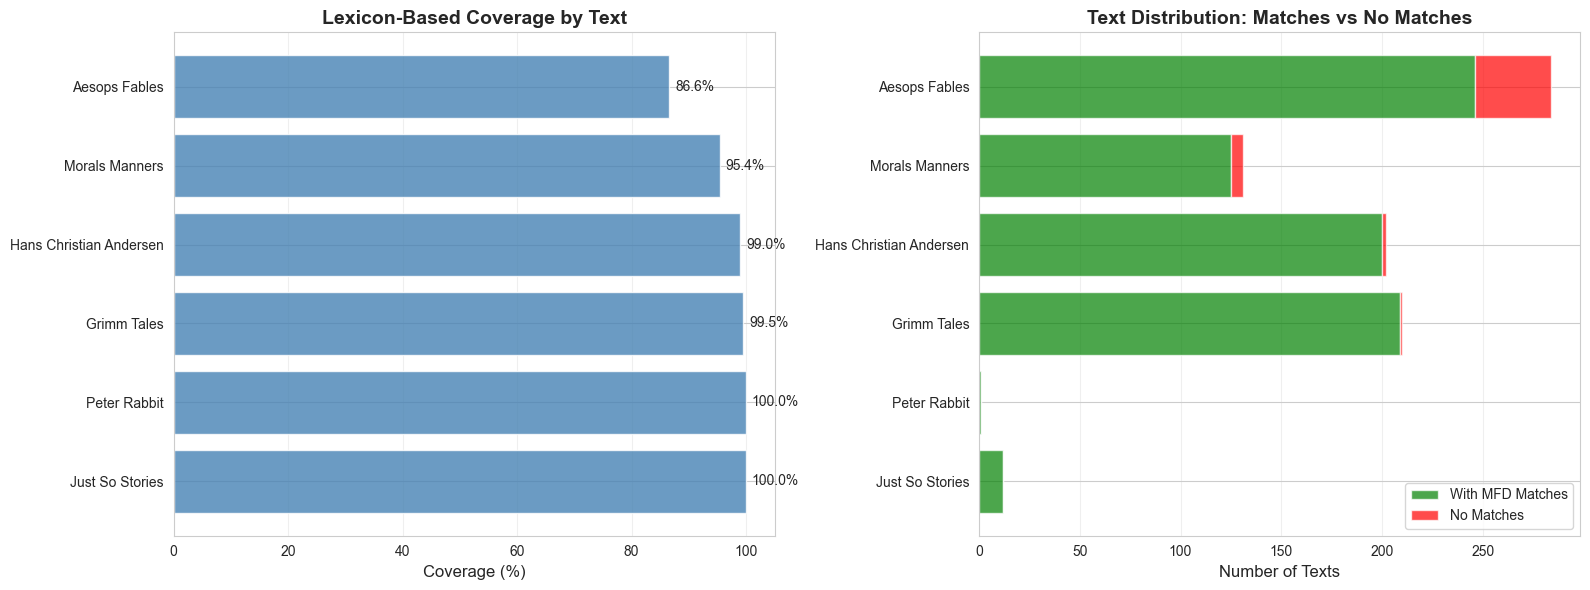


Coverage Summary:
                   Text  Total  With Matches  Coverage (%)
        Just So Stories     12            12    100.000000
           Peter Rabbit      1             1    100.000000
            Grimm Tales    210           209     99.523810
Hans Christian Andersen    202           200     99.009901
         Morals Manners    131           125     95.419847
          Aesops Fables    284           246     86.619718


In [8]:
# Create coverage comparison chart
coverage_data = []
for text_name, lex_df in lexicon_results.items():
    total = len(lex_df)
    with_matches = lex_df['dominant_moral_lexicon'].notna().sum()
    coverage_pct = with_matches / total * 100
    coverage_data.append({
        'Text': text_name.replace('_', ' ').title(),
        'Total': total,
        'With Matches': with_matches,
        'Coverage (%)': coverage_pct
    })

coverage_df = pd.DataFrame(coverage_data).sort_values('Coverage (%)', ascending=False)

# Plot coverage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1.barh(coverage_df['Text'], coverage_df['Coverage (%)'], color='steelblue', alpha=0.8)
ax1.set_xlabel('Coverage (%)', fontsize=12)
ax1.set_title('Lexicon-Based Coverage by Text', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(coverage_df['Coverage (%)']):
    ax1.text(v + 1, i, f"{v:.1f}%", va='center', fontsize=10)

# Stacked bar chart
texts = coverage_df['Text']
with_matches = coverage_df['With Matches']
without_matches = coverage_df['Total'] - coverage_df['With Matches']

ax2.barh(texts, with_matches, label='With MFD Matches', color='green', alpha=0.7)
ax2.barh(texts, without_matches, left=with_matches, label='No Matches', color='red', alpha=0.7)
ax2.set_xlabel('Number of Texts', fontsize=12)
ax2.set_title('Text Distribution: Matches vs No Matches', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCoverage Summary:")
print(coverage_df.to_string(index=False))

## 8. Dominant Moral Distribution Comparison

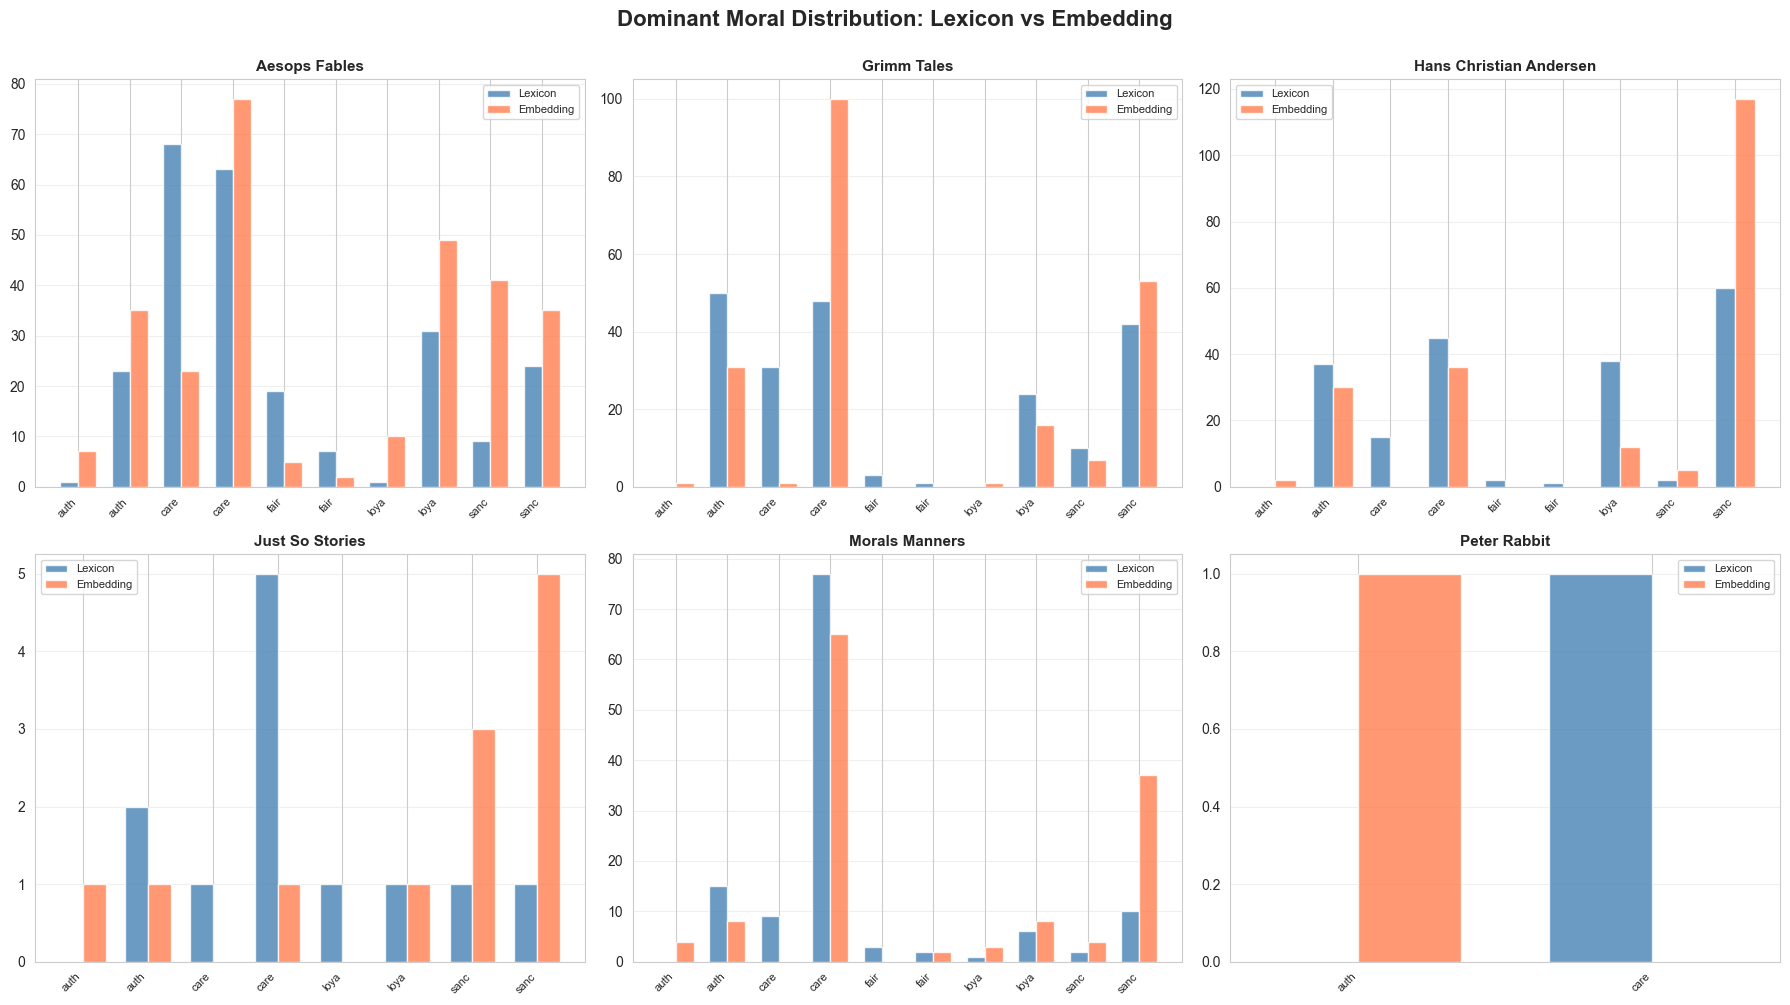

In [9]:
# Compare dominant moral distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (text_name, compare_df) in enumerate(comparison_results.items()):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Count dominant morals
    lex_counts = compare_df['dominant_lexicon'].value_counts()
    emb_counts = compare_df['dominant_embedding'].value_counts()
    
    # Combine for comparison
    all_morals = set(lex_counts.index) | set(emb_counts.index)
    lex_vals = [lex_counts.get(m, 0) for m in sorted(all_morals)]
    emb_vals = [emb_counts.get(m, 0) for m in sorted(all_morals)]
    
    x = np.arange(len(all_morals))
    width = 0.35
    
    ax.bar(x - width/2, lex_vals, width, label='Lexicon', alpha=0.8, color='steelblue')
    ax.bar(x + width/2, emb_vals, width, label='Embedding', alpha=0.8, color='coral')
    
    ax.set_title(text_name.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.split('.')[0][:4] for m in sorted(all_morals)], rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Remove extra subplots
for idx in range(len(comparison_results), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Dominant Moral Distribution: Lexicon vs Embedding', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Score Correlation Analysis

In [10]:
# Calculate correlations for each text
print("="*70)
print("SCORE CORRELATION ANALYSIS (Spearman's ρ)")
print("="*70)

all_correlations = {}

for text_name in lexicon_results.keys():
    if text_name not in embedding_data:
        continue
    
    print(f"\n--- {text_name.upper()} ---")
    
    lex_df = lexicon_results[text_name]
    emb_df = embedding_data[text_name]
    
    correlations = {}
    
    for moral in moral_foundations:
        if moral in lex_df.columns and moral in emb_df.columns:
            lex_scores = lex_df[moral]
            emb_scores = emb_df[moral]
            
            try:
                corr, pval = spearmanr(lex_scores, emb_scores)
                correlations[moral] = corr
                if not np.isnan(corr):
                    print(f"  {moral:20s}: ρ = {corr:6.3f} (p = {pval:.4f})")
            except:
                correlations[moral] = np.nan
    
    all_correlations[text_name] = correlations
    
    valid_corrs = [c for c in correlations.values() if not np.isnan(c)]
    if valid_corrs:
        print(f"  Mean correlation: {np.mean(valid_corrs):.3f}")

print("\n" + "="*70)

SCORE CORRELATION ANALYSIS (Spearman's ρ)

--- AESOPS_FABLES ---
  care.virtue         : ρ =  0.183 (p = 0.0019)
  care.vice           : ρ =  0.172 (p = 0.0037)
  fairness.virtue     : ρ =  0.041 (p = 0.4885)
  fairness.vice       : ρ =  0.012 (p = 0.8410)
  loyalty.virtue      : ρ =  0.136 (p = 0.0216)
  loyalty.vice        : ρ =  0.114 (p = 0.0548)
  authority.virtue    : ρ =  0.050 (p = 0.3967)
  authority.vice      : ρ =  0.054 (p = 0.3652)
  sanctity.virtue     : ρ =  0.107 (p = 0.0708)
  sanctity.vice       : ρ =  0.112 (p = 0.0599)
  Mean correlation: 0.098

--- GRIMM_TALES ---
  care.virtue         : ρ =  0.223 (p = 0.0012)
  care.vice           : ρ =  0.194 (p = 0.0047)
  fairness.virtue     : ρ =  0.005 (p = 0.9480)
  fairness.vice       : ρ =  0.019 (p = 0.7811)
  loyalty.virtue      : ρ =  0.151 (p = 0.0289)
  loyalty.vice        : ρ =  0.053 (p = 0.4491)
  authority.virtue    : ρ =  0.104 (p = 0.1316)
  authority.vice      : ρ =  0.115 (p = 0.0968)
  sanctity.virtue     : 

## 10. Summary and Conclusions

In [11]:
print("="*70)
print("SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON")
print("ALL ENGLISH TEXTS")
print("="*70)

print("\n📊 OVERALL STATISTICS:")
print(f"  - Total texts analyzed: {total_texts}")
print(f"  - Texts with lexicon matches: {total_with_matches} ({total_coverage:.1f}%)")
print(f"  - Overall agreement rate: {overall_agreement:.1f}%" if all_comparisons > 0 else "  - Overall agreement rate: N/A")

print("\n✅ EMBEDDING-BASED ADVANTAGES:")
print("  1. 100% coverage - works on ALL texts")
print("  2. Captures semantic similarity (synonyms, paraphrases)")
print("  3. More nuanced - continuous scores instead of binary")
print("  4. Better for narrative texts (stories, fables, fairy tales)")

print("\n✅ LEXICON-BASED ADVANTAGES:")
print("  1. Fast - no GPU needed")
print("  2. Interpretable - easy to see why a text scores high")
print("  3. Transparent - can trace back to specific words")
print("  4. Simple baseline for comparison")

print("\n⚠️ KEY FINDINGS:")
print(f"  - Average lexicon coverage: {total_coverage:.1f}%")
print(f"  - {100-total_coverage:.1f}% of texts have NO exact MFD word matches")
print(f"  - Agreement varies significantly across different texts")
print(f"  - Fables show different patterns than fairy tales")

print("\n🎯 RECOMMENDATIONS:")
print("  1. Use EMBEDDING-BASED approach as primary method")
print("  2. Use LEXICON-BASED as validation/interpretability tool")
print("  3. When both agree → high confidence in moral classification")
print("  4. When they disagree → manual inspection recommended")
print("  5. Consider text-specific characteristics when interpreting results")

print("\n📚 TEXTS ANALYZED:")
for text_name, df in texts_data.items():
    coverage = (lexicon_results[text_name]['dominant_moral_lexicon'].notna().sum() / len(df)) * 100
    print(f"  - {text_name.replace('_', ' ').title()}: {len(df)} texts ({coverage:.1f}% coverage)")

print("\n" + "="*70)

SUMMARY: LEXICON-BASED VS EMBEDDING-BASED COMPARISON
ALL ENGLISH TEXTS

📊 OVERALL STATISTICS:
  - Total texts analyzed: 840
  - Texts with lexicon matches: 793 (94.4%)
  - Overall agreement rate: 31.0%

✅ EMBEDDING-BASED ADVANTAGES:
  1. 100% coverage - works on ALL texts
  2. Captures semantic similarity (synonyms, paraphrases)
  3. More nuanced - continuous scores instead of binary
  4. Better for narrative texts (stories, fables, fairy tales)

✅ LEXICON-BASED ADVANTAGES:
  1. Fast - no GPU needed
  2. Interpretable - easy to see why a text scores high
  3. Transparent - can trace back to specific words
  4. Simple baseline for comparison

⚠️ KEY FINDINGS:
  - Average lexicon coverage: 94.4%
  - 5.6% of texts have NO exact MFD word matches
  - Agreement varies significantly across different texts
  - Fables show different patterns than fairy tales

🎯 RECOMMENDATIONS:
  1. Use EMBEDDING-BASED approach as primary method
  2. Use LEXICON-BASED as validation/interpretability tool
  3. Wh

## 11. Save Results

In [12]:
# Create output directory if it doesn't exist
os.makedirs('lexicon-comparison-results', exist_ok=True)

# Save lexicon results
for text_name, df in lexicon_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_lexicon_scores.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save comparison results
for text_name, df in comparison_results.items():
    output_file = f'lexicon-comparison-results/{text_name}_method_comparison.csv'
    df.to_csv(output_file, index=False)
    print(f"✓ Saved {output_file}")

# Save aggregate statistics
coverage_df.to_csv('lexicon-comparison-results/coverage_summary.csv', index=False)
print(f"✓ Saved lexicon-comparison-results/coverage_summary.csv")

print("\n✓ All results saved to lexicon-comparison-results/ folder")

✓ Saved lexicon-comparison-results/aesops_fables_lexicon_scores.csv
✓ Saved lexicon-comparison-results/grimm_tales_lexicon_scores.csv
✓ Saved lexicon-comparison-results/hans_christian_andersen_lexicon_scores.csv
✓ Saved lexicon-comparison-results/just_so_stories_lexicon_scores.csv
✓ Saved lexicon-comparison-results/morals_manners_lexicon_scores.csv
✓ Saved lexicon-comparison-results/peter_rabbit_lexicon_scores.csv
✓ Saved lexicon-comparison-results/aesops_fables_method_comparison.csv
✓ Saved lexicon-comparison-results/grimm_tales_method_comparison.csv
✓ Saved lexicon-comparison-results/hans_christian_andersen_method_comparison.csv
✓ Saved lexicon-comparison-results/just_so_stories_method_comparison.csv
✓ Saved lexicon-comparison-results/morals_manners_method_comparison.csv
✓ Saved lexicon-comparison-results/peter_rabbit_method_comparison.csv
✓ Saved lexicon-comparison-results/coverage_summary.csv

✓ All results saved to lexicon-comparison-results/ folder
